# Project

## load libraries

In [6]:
import matplotlib.pyplot as py
import numpy as np
import random

## Geometry Operations

In [ ]:
def direct_mapp(img, factor: int, type_: bool):
    """
    Apply Direct Map 0-order to resize the image, and change width and height with the same factor.

    Direct Map is a Geometry Operation that enhances the image by changing the location of a pixel.
    **Zooming in, only**
    :param img: the source image, should (gray | RGB)
    :param factor: the extent to which the image is zoomed from the input image
    :param type_: 0-order | 1-order
    :return: new resized (enhanced) image
    """

    shape = np.shape(img)

    # region Check on the parameters
    # check on factor for zooming in
    if factor < 1: raise ValueError("Factor must bigger than 1")
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape
    n_h, n_w = int(h * factor), int(w * factor)
    new_img = np.zeros((n_h, n_w, chs), np.uint8)

    # region Code
    def zero_order():
        """
        just repeat old-pixels, in the kernel "shape(factor, factor)".
        """
        # assign to new image
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    new_img[r * factor: (r + 1) * factor,  c * factor: (c + 1) * factor, ch] = img[r, c, ch]
                    pass
                pass
            pass
        pass
    def one_order():
        """
        apply this equation on image:
        new_image = round(((max_pixel - min_pixel) / factor) * i) + min_pixel)
        """

        step, ind_min, min_pi = 0,0,0
        for ch in range(chs):
            # O(h * (w * factor))
            # fill pixels of main rows
            for r in range(h):
                # fil the main pixels
                # i.e, assign the pixels from old image into the new position in new image
                cur_row = r * factor
                new_img[cur_row, 0, ch] = img[r, 0, ch]

                # fil the pixels between the main pixels
                for c in range(1, w):
                    pi_pr, pi_cur = (c - 1) * factor,  c * factor
                    # fil the main pixels
                    new_img[cur_row, pi_cur, ch] = img[r, c, ch]

                    # get the minimum pixel in current row between adjacent two-pixels.
                    if new_img[cur_row, pi_pr , ch] < new_img[cur_row, pi_cur, ch]:
                        min_pi , ind_min = new_img[cur_row, pi_pr , ch], pi_pr
                        step = (new_img[cur_row, pi_cur , ch] - min_pi) / factor
                        pass
                    else:
                        min_pi , ind_min = new_img[cur_row, pi_cur , ch], pi_cur
                        step = (new_img[cur_row, pi_pr , ch] - min_pi) / factor
                        pass

                    # fill pixels between adjacent two-pixels
                    for p in range(pi_pr+ 1, pi_cur):
                        new_img[cur_row, p, ch] = round((step * abs(p - ind_min)) + min_pi)
                        pass
                pass

                # fill remained pixels, after the last pixel in the row in original image
                o = (w - 1) * factor
                new_img[cur_row,  o:, ch] = new_img[cur_row, o, ch]
                pass

            step, ind_min, min_pi = 0, 0, 0
            # O((h * factor) * n_w)
            # fill pixels of remained rows
            for c in range(n_w):
                for r in range((h - 1) * factor):
                    # skip main rows in assigning operation
                    if r % factor == 0:
                        # get the minimum pixel in current column between adjacent two-pixels.
                        pi_cur, pi_nxt = r,  r + factor
                        if new_img[pi_cur, c, ch] < new_img[pi_nxt, c, ch]:
                            min_pi , ind_min = new_img[pi_cur, c , ch], pi_cur
                            step = (new_img[pi_nxt, c , ch] - min_pi) / factor
                            pass
                        else:
                           min_pi , ind_min = new_img[pi_nxt, c , ch], pi_nxt
                           step = (new_img[pi_cur, c, ch] - min_pi) / factor
                           pass
                    else:
                        # fill pixels between adjacent two-pixels
                        new_img[r, c, ch] = round((step * abs(r - ind_min)) + min_pi); pass
                    pass

                # fill remained pixels, after the last pixel in the row in original image
                o = (h - 1) * factor
                new_img[o + 1: ,  c, ch] =  new_img[o,  c, ch]
                pass

            pass

        pass
    # endregion

    if type_: one_order()
    else: zero_order()

    return new_img

In [ ]:
def reverse_mapp(img, h_factor: int, w_factor: int, type_: bool):
    """
    Apply Reverse Map to resize the image, and change width with *w_factor* and height with *h_factor*.

    Reverse Map is a Geometry Operation that enhances the image by changing the location of a pixel.
    **Zooming in, only**
    :param img: the source image, should (gray | RGB)
    :param h_factor: the extent to which the height of the image is zoomed from the input image
    :param w_factor: the extent to which the width of the image is zoomed from the input image
    :param type_: 0-order | 1-order
    :return: new resized (enhanced) image
    """

    shape = np.shape(img)

    # region Check on the parameters
    # check on factor for zooming in
    if w_factor < 1 | h_factor < 1: raise ValueError("Factors must bigger than 1")
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape
    n_h, n_w = h * h_factor, w * w_factor
    new_img = np.zeros((n_h, n_w, chs), np.uint8)

    # region Code
    if type_:
        for ch in range(chs):
            for r in range(n_h):
                for c in range(n_w):
                    # the corresponding pixel to the current pixel
                    x, y = r * (1 / h_factor), c * (1 / w_factor)
                    x1 = int(np.floor(x)); y1 = int(np.floor(y))

                    x_frac, y_frac = x - x1,  y - y1

                    # avoid out of boundary
                    if x1 >= (h - 1): x1 = h - 2
                    if y1 >= (w - 1): y1 = w - 2

                    # 4-corresponding pixels to the current
                    p1, p2, p3, p4 = img[x1, y1 , ch], img[x1 + 1, y1 + 1 , ch], \
                        img[x1 + 1, y1 , ch], img[x1, y1 + 1 , ch]

                    # calculate the pixel value
                    z1 = p1 * (1 - x_frac) + p2 * x_frac
                    z2 = p3 * (1 - x_frac) + p4 * x_frac

                    # assign new pixel to new image
                    new_p = z1 * (1 - y_frac)  + z2 * y_frac
                    new_img[r, c, ch] = new_p

                    pass
                pass
            pass
        pass
    else:
        for ch in range(chs):
            for r in range(n_h):
                for c in range(n_w):
                   # the corresponding pixel to the current pixel
                    x, y = round(r / h_factor), round(c / w_factor)

                    # avoid out of boundary
                    if x >= h: x = h - 1
                    if y >= w: y = w - 1

                    new_img[r, c, ch] = img[x, y, ch]
                    pass
                pass
            pass
        pass
    # endregion

    return new_img

## Pixel Operations

In [8]:
def gray_simple(img, chanel):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :param chanel: what channel, to keep it [0 | 1 | 2]
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return img[:,:, chanel]
def gray_avg(img):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return ((img[:, :, 0] + img[:, :, 1] + img[:, :, 2] ) / 3).astype(np.uint8)
def gray_lum(img, alpha, beta, gamma):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :param alpha: red chanel correlation
    :param beta: green chanel correlation
    :param gamma: blue chanel correlation
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return ((img[:, :, 0] * alpha) + (img[:, :, 1] * beta) + (img[:, :, 2] * gamma)).astype(np.uint8)
def gray_dest(img):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return ((np.maximum(img[:, :, 0], np.maximum(img[:, :, 1], img[:, :, 2])) + \
             np.minimum(img[:, :, 0], np.minimum(img[:, :, 1], img[:, :, 2]))) / 2).astype(np.uint8)
def gray_max(img):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return (np.maximum(img[:, :, 0], np.maximum(img[:, :, 1], img[:, :, 2]))).astype(np.uint8)
def gray_min(img):
    """
     Convert to RGB image to gray scale
    :param img: the source image, should RGB
    :return: new enhanced image
    """

    # region Check on the parameters
    # check in the third-dimension isn't correct for images shape
    shape = np.shape(img)
    if shape[2] != 3 :
        mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              3 for RGB image
        """
        raise TypeError(mess)
    # endregion

    return (np.minimum(img[:, :, 0], np.minimum(img[:, :, 1], img[:, :, 2]))).astype(np.uint8)

In [ ]:
def brightness(img, offset):
    """
    Change the intensity of image pixels.\n
    Brightness is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the source image, should (gray | RGB)
    :param offset: how the changing in the brightness of image, positive move to lightness or negative move to darkness
    :return: new enhanced image
    """

    shape = np.shape(img)

    # to write in image
    img = img.copy()
    # region Check on the parameters
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape

    # region Code
    pixel = 0
    for ch in range(chs):
        for r in range(h):
            for c in range(w):
                pixel = img[r, c, ch] + offset

                # convert into scale
                if pixel > 255: pixel = 255
                if pixel < 0: pixel = 0

                img[r, c, ch] = pixel
                pass
            pass
        pass
    # endregion

    return img

In [ ]:
def calculate_histogram(img):
    """
     Histogram of image is number of unique pixels that make image
    :param img: the source image, should (gray | RGB)
    :return: the histogram of image
    """

    shape = np.shape(img)

    # region Check on the parameters
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape
    colors = {}
    # colors = np.unique(img, return_counts=True)
    for ch in range(chs):
        for r in range(h):
            for c in range(w):
                if img[r, c, ch] not in colors:
                    colors[img[r, c, ch]] = 1
                    pass
                else:
                    colors[img[r, c, ch]] += 1
                    pass
                pass
            pass
        pass

    py.scatter(colors.keys(), colors.values())
    py.xlabel('pixels'); py.ylabel("count"); py.title("Histogram of image"); py.show()
    # endregion

    return colors

In [30]:
def contrast(img, new_min: int, new_max: int):
    """
    Contrast change scale of image histogram. i.e, make scaling of image.\n
    Contrast is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the source image, should (gray | RGB)
    :param new_min: minimum pixel in new range
    :param new_max: maximum pixel in new range
    :return: new enhanced image
    """

    shape = np.shape(img)

    # region Check on the parameters
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    # region Code
    h , w, ch = np.shape(img)
    new_img = np.zeros((h , w, ch), np.uint8)
    for i in range(ch):
        # get min & max from image
        min = np.min(img[:,:,i])
        max = np.max(img[:,:,i])

        for r in range(h):
            for c in range(w):
                # calculate corresponding pixel value
                pixel = (img[r,c,i] - min) / (max - min) * (new_max - new_min) + new_min

                # convert into scale
                if pixel > 255: pixel = 255
                if pixel < 0: pixel = 0

                new_img[r,c,i] = pixel
                pass
            pass
        pass
    # endregion

    return  new_img

In [ ]:
def power_law_transform(img, gamma):
    """
    Power-Law Transform change image histogram distribution into normal distribution.

    Power-Law Transform is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the source image, should (gray | RGB)
    :param gamma:
    :return: new enhanced image
    """

    shape = np.shape(img)

    # region Check on the parameters
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    new_img = (np.power(img, gamma)).astype(np.uint8)

    return contrast(new_img,0,255)

In [ ]:
def hist_equalization(img):
    """
    Histogram Equalization change image histogram distribution into uniform distribution.

     Histogram Equalization is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the source image, should (gray | RGB)
    :return: unique pixels and their new values.
    """

    # histogram equalization
    values, counts = np.unique(img, return_counts=True)
    cms = np.cumsum(counts); new_pixels = np.round((cms / cms[-1]) * values)

    return values, new_pixels

In [ ]:
def fit_equalization(img):
    """
    Apply hist_equalization on image
    :param img: the source image, should (gray | RGB)
    :return: new enhanced image
    """

    # to write in image
    img = img.copy()
    # region Check on the parameters
    shape = np.shape(img)
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    # region Code

    # histogram equalization
    values, new_pixels =  hist_equalization(image)

    # apply on image
    for i in range(len(values)): img[np.where(img == values[i])] = new_pixels[i]
    # endregion

    return img

In [ ]:
def hist_matching(src_img, targ_img):
    """
    Histogram Matching change image histogram distribution as the target histogram distribution.\n
    Histogram Equalization is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param src_img: the source image, should (gray | RGB)
    :param targ_img: the target image, should (gray | RGB)
    :return: new enhanced image
    """

    # region Check on the parameters
    src_img = src_img.copy()
    shape_src = np.shape(src_img)
    shape_targ = np.shape(targ_img)
    try:
        # check in the third-dimension isn't correct for images shape
        if (shape_src[2] != 3 & shape_src[2] != 1) | (shape_targ[2] != 3 & shape_targ[2] != 1):
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape_src = shape_src + (1, )
        src_img = np.reshape(src_img, shape_src)

        shape_targ = shape_targ + (1, )
        targ_img = np.reshape(targ_img, shape_targ)
        pass
    # endregion

    # region Code
    def get_nearest(source_values, target_values):
        s_len, t_len = len(source_values), len(target_values)
        indexes = []
        for s_v in range(s_len):
            min_diff, min_index = 300, 300
            # get the nearest value to the source values
            for t_v in range(t_len):
                diff = abs(source_values[s_v] - target_values[t_v])
                if diff == 0:
                    min_index = t_v; break
                if diff < min_diff: min_diff, min_index = diff, t_v
                pass
            indexes.append(min_index)
            pass

        return indexes

    src_hist, targ_hist = hist_equalization(src_img), hist_equalization(targ_img)
    src_values, src_pixels = src_hist; targ_values, targ_pixels = targ_hist
    nearest_pxs = get_nearest(src_pixels, targ_pixels)

    colors = targ_values[nearest_pxs]
    # apply on image
    for i in range(len(src_values)): src_img[np.where(src_img == src_values[i])] = colors[i]
    # endregion

    return src_img

In [ ]:
def image_algebra(first_img, second_image, type: str):
    """
    Apply algebra on 2-images
    :param first_img: the first image, should (gray | RGB)
    :param second_image: the second image, should (gray | RGB)
    :param type: + | -
    :return: new enhanced image
    """

    # region Check on the parameters
    shape_src = np.shape(first_img)
    shape_targ = np.shape(second_image)
    try:
        if (shape_src[0] != shape_targ[0]) | (shape_src[1] != shape_targ[1]):raise "Must have the same shape"
        # check in the third-dimension isn't correct for images shape
        if (shape_src[2] != 3 & shape_src[2] != 1) | (shape_targ[2] != 3 & shape_targ[2] != 1):
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
        if shape_src[2] != shape_targ[2] : raise "Must have the same shape"
    except IndexError:
        # in case 2d array
        shape_src = shape_src + (1, )
        first_img = np.reshape(first_img, shape_src)

        shape_targ = shape_targ + (1, )
        second_image = np.reshape(second_image, shape_targ)
        pass
    # endregion
    new_image = np.zeros(shape_src, np.uint8)
    h, w, chs = shape_src

    if type == '+':
         for ch in range(chs):
             for r in range(h):
                 for c in range(w):
                     pixel = int(first_img[r, c, ch]) + int(second_image[r, c, ch])

                     if pixel > 255: pixel = 255

                     new_image[r, c, ch] = pixel
                     pass
                 pass
             pass
         pass
    elif type == '-':
         for ch in range(chs):
             for r in range(h):
                 for c in range(w):
                     pixel = int(first_img[r, c, ch]) - int(second_image[r, c, ch])

                     if pixel < 0: pixel = 0

                     new_image[r, c, ch] = pixel
                     pass
                 pass
             pass
         pass
    else: raise "Wrong operation"

    return new_image

In [ ]:
def image_negotiation(img):
    """
    Apply algebra on 2-images.\n
    Histogram Equalization is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the input image, should (gray | RGB)
    :return: new enhanced image
    """

    # region Check on the parameters
    shape = np.shape(img)
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    # region Code
    h, w, chs = shape
    img = img.copy()
    for ch in range(chs):
        for r in range(h):
            for c in range(w):
                img[r,c,ch] = 255 - img[r,c,ch]
    # endregion
    return img

In [ ]:
def image_quantization(img, k: int):
    """
    Image quantization is used to reduce the storage required to store the imag.\n
    Reduce the number of bits that store a pixel.\n
    Image Quantization is a Pixel Operation that enhances the image by changing in the intensity(value) of a pixel.
    :param img: the input image, should (gray | RGB)
    :param k: number of bits to store a pixel, represent the number of gray-levels in image.
    :return: new enhanced image
    """

    # region Check on the parameters
    shape = np.shape(img)
    if k < 1 | k > 8: raise "number of bits must between 1 and 8.\n available gray-levels"
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    # region Code
    h, w, chs = shape
    # to write in image
    img = img.copy()

    # number of pixels in each group, number of gray-levels is 2 ** k.
    gap = 256 / (2 ** k)

    for ch in range(chs):
        for r in range(h):
            for c in range(w):
                # index of color in new space (gray-levels).
                i = int(img[r, c, ch] / gap)
                # replace pixel-color with corresponded color in new space,
                # that represent of a group of pixels.
                # the first pixel in group is represented of this group.
                img[r, c, ch] = i * gap
                pass
            pass
        pass
     # endregion

    return img

## Neighbours pixel Operation

In [9]:
def add_padding(img, k, type: False):
        """
        Add padding to the image.\n
        Add new rows and columns to the image
        :param img: input image.
        :param k: kernel size
        :param type: type of padding add zeros (False) or replicating the first and last row & column (True).
        :return: padded image
        """

        h, w, chs = np.shape(img)
        k_ = (k // 2); new_img = np.zeros((h + (k_ * 2), w + (k_ * 2), chs), np.uint8)
        if type:
            # fill new rows
            for ch in range(chs):
                for r in range(k_):
                    for c in range(w):
                        # top new rows
                        new_img[r, c + k_ , ch] = img[0, c, ch]
                        # bottom new rows
                        new_img[h + r + k_, c + k_ , ch] = img[-1, c, ch]
                        pass
                    pass
                pass

            # fill new columns
            for ch in range(chs):
                for r in range(h):
                    for c in range(k_):
                        # left new columns
                        new_img[r + k_, c , ch] = img[r, 0, ch]
                        # right new columns
                        new_img[r + k_, w + c + k_ , ch] = img[r, -1, ch]
                        pass
                    pass
                pass

            # fil corners
            for ch in range(chs):
                for r in range(k_):
                    for c in range(k_):
                        new_img[r, c, ch] = img[0, 0, ch] # top left
                        new_img[r, c + w + k_, ch] = img[0, -1, ch] # top right
                        new_img[r + h + k_, c + w + k_, ch] = img[-1, -1, ch] # bottom right
                        new_img[r + h + k_, c, ch] = img[-1, 0, ch] # bottom left
                        pass
                    pass
                pass

            pass

        # fill original pixels
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    new_img[r + k_, c + k_, ch] = img[r, c, ch]
                    pass
                pass
            pass

        return new_img

In [14]:
def aplay_filter(img, filter: np.ndarray,  type: bool, type_filter = True):
    """
    Apply filter in image
    :param img: the input image, should (RGB | gray)
    :param filter: filter matrix
    :param type: type of padding add zeros (False) or replicating the first and last row & column (True).
    :param type_filter: Arithmetic filter (True) | Geometric filter (False)
    :return: new image
    """

    # region Check on the parameters
    shape = np.shape(img)
    shape_fil = np.shape(filter)

    if shape_fil[0] != shape_fil[1]: raise "Filter should have equal rows and columns"
    if shape_fil[0] % 2 != 1: raise "Kernel Size should be odd number"
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)

    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion
    h, w, chs = shape; k = shape_fil[0]

    def calculate_value_arth(window):
        """
        Calculate value of new adjacent pixel
        :param window: the pixels to which the calculation is applied.
        :return: new pixel value
        """
        value = 0
        for i in range(k):
            for j in range(k):
                value += window[i, j] * filter[i, j]
            pass
        if value < 0:return 0
        if value > 255: return 255
        return np.uint8(value)

    def calculate_value_geom(window):
        """
        Calculate value of new adjacent pixel
        :param window: the pixels to which the calculation is applied.
        :return: new pixel value
        """
        value = 1
        for i in range(k):
            for j in range(k):
                value *= window[i, j] * filter[i, j]
            pass

        # value = np.power(value, (1/ k ** 2)) # instance of this make filter contains the sqr of correlation.
        if value < 0:return 0
        if value > 255: return 255
        return np.uint8(value)

    img = img.copy()
    new_img = add_padding(img, k, type)

    if type_filter:
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    img[r, c, ch] = calculate_value_arth(new_img[r: r+k, c: c+k, ch])
                    pass
                pass
            pass
        pass
    else :
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    img[r, c, ch] = calculate_value_geom(new_img[r: r+k, c: c+k, ch])
                    pass
                pass
            pass
        pass

    return img

### Filters

In [ ]:
def smoothing_avg(img, k = 3, type_padding = False):
    """
    Smoothing is useful, in remove noise pixels in images & remove small details include bridge small gaps in lines and
    extract objects.\n
    Smoothing is Neighbor Operation that enhance image by change the pixel value based on its adjacent (neighbor) pixels.
    :param img: the input image, should (RGB | gray)
    :param k: kernel size
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new smoothed image
    """

    # apply average
    filter =  np.zeros((k, k))
    filter[:, :] = 1 / (k*k)
    return aplay_filter(img, filter, type_padding)
def smoothing_gaussian(img, siqma, type_padding = False):
    """
    Smoothing is useful, in remove noise pixels in images & remove small details include bridge small gaps in lines and
    extract objects.\n
    Smoothing is Neighbor Operation that enhance image by change the pixel value based on its adjacent (neighbor) pixels.
    :param img: the input image, should (RGB | gray)
    :param siqma: kernel size
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new smoothed image
    """

    k = 2 * (int(3.7 * (siqma - 0.5))) + 1
    filter =  np.zeros((k, k))

    siqma = siqma**2
    for i in range(k):
        for j in range(k):
            # apply Gaussian formula
            filter[i, j] = (1 / (2 * 3.14 * siqma)) * (2.718 ** (-1 * ( (i**2 + j**2) / (2 * siqma))))
            pass
        pass
    return aplay_filter(img, filter, type_padding)

def smoothing_nonlinear(img, type_smoothing: int,  k = 3, type_padding = False):
    """
    Smoothing is useful, in remove noise pixels in images & remove small details include bridge small gaps in lines and
    extract objects.\n
    Smoothing is Neighbor Operation that enhance image by change the pixel value based on its adjacent (neighbor) pixels.
    :param img: the input image, should (RGB | gray)
    :param type_smoothing: type of non-linear filter, 0 (median) | 1 (min) | 2 (max)
    :param k: kernel size
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new smoothed image
    """

    # region Check on the parameters
    shape = np.shape(img)
    if k % 2 != 1: raise "Kernel Size should be odd number"
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)

    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape

    img = img.copy()
    new_img = add_padding(img, k, type_padding)

    if type_smoothing == 0:
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    img[r, c, ch] = np.median(new_img[r: r+k, c: c+k, ch])
                pass
            pass
        pass
    elif type_smoothing == 1:
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    img[r, c, ch] = np.min(new_img[r: r+k, c: c+k, ch])
                pass
            pass
        pass
    elif type_smoothing == 2:
        for ch in range(chs):
            for r in range(h):
                for c in range(w):
                    img[r, c, ch] = np.max(new_img[r: r+k, c: c+k, ch])
                pass
            pass
        pass
    else: raise "type_smoothing Must 0 | 1 | 2"

    return img

In [28]:
def edge_detection(img, type_edge: int,  type_padding = False):
    """
    Edge Detection is useful in Segmentation.
    Edge Detection is Neighbor Operation that enhance image by change the pixel value based on its adjacent (neighbor) pixels.
    :param img: the input image, should gray
    :param type_edge: type of edge detection filter, 0 (Laplacian) | 1 (Prewitt x-axis) | 2 (Prewitt y-axis)
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new enhanced image
    """

    img = img.copy()
    try:
        if np.shape(img)[2] != 1: raise TypeError("Must gray-scale image")
    except IndexError: pass

    if type_edge == 0: return contrast(aplay_filter(img, np.array([
        [
           0, 1, 0
        ],
        [
            1, -4, 1
        ],
        [
            0, 1, 0
        ]
    ]), type_padding), 0, 1)
    elif type_edge == 1: return contrast(aplay_filter(img, np.array([
        [
           -1, 0, 1
        ],
        [
            -1, 0, 1
        ],
        [
            -1, 0, 1
        ]
    ]), type_padding), 0, 1)
    elif type_edge == 2: return contrast(aplay_filter(img, np.array([
        [
           -1, -1, -1
        ],
        [
            0, 0, 0
        ],
        [
            1, 1, 1
        ]
    ]), type_padding), 0, 1)
    else: raise TypeError("type_smoothing Must 0 | 1 | 2")

In [ ]:
def sharping(img, type_padding = False):
    """
    Sharping is useful to focus on high details
    :param img: the input image, should (RGB | gray)
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new sharped image
    """

    return aplay_filter(img, np.array([
        [
           0, -1, 0
        ],
        [
            -1, 5, -1
        ],
        [
            0, -1, 0
        ]
    ]), type_padding)
def unsharping(img, type_padding = False, k = 3):
    """
    Sharping is useful to focus on high details
    :param img: the input image, should (RGB | gray)
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :param k: the kernel size
    :return: new sharped image
    """

    return image_algebra(
        # subtract original image from smoothed image
        image_algebra(img,
                      smoothing_avg(img, k=k, type_padding=type_padding), '-') # convert to smoothed image
        , img, '+') # sum original image anf output image

## Filters on Frequency Domain

In [ ]:
distance = lambda pixel, centre: np.sqrt(((pixel[0] - centre[0])** 2) + ((pixel[1] - centre[1])** 2) )
def lowpass(img, type_pass:int, threshold:int , n= None):
    """
    Low pass is used to make smoothing
    :param img: Input image, should be gray image
    :param type_pass: type of filter 0 (ideal) | 1 (butterworth) | 2(guassiam)
    :param threshold: the value that determine, which pixels are passed
    :param n: for butterworth
    :return: new enhanced image
    """

    # region Check on the parameters
    shape = np.shape(img)
    # check in the third-dimension isn't correct for images shape
    if len(shape) != 2:
            mess = """"
        Image must have 2 dimension (h, w,).
         gray-level image
        """
            raise TypeError(mess)
    # endregion

    # transform into frequency domain
    for_img = np.fft.fftshift(np.fft.fft2(img))
    # get real & imagine parts of image
    real_img, imag_img = np.real(for_img), np.imag(for_img)

    h, w = img.shape
    py.imshow(np.log1p(np.abs(for_img)), cmap='gray')
    py.title("Image in Frequency Domain"); py.show()

    # centre of matrix
    cen_pix = (h / 2, w / 2)
    img_mat = np.zeros(shape, dtype=np.float32)

    if type_pass == 0:
        for i in range(h):
            for j in range(w):
                if distance((i,j), cen_pix) <= threshold: img_mat[i, j] = 1
        pass
    elif type_pass == 1:
        for i in range(h):
            for j in range(w):
                img_mat[i, j] = 1 / (1 + (distance((i,j), cen_pix)/ threshold)**n)
        pass
    elif type_pass == 2:
        for i in range(h):
            for j in range(w):
                img_mat[i, j] = np.exp((-1 * (distance((i,j), cen_pix)**2)) / (2* (threshold**2)))
        pass

    # apply mask on real and imagine parts.
    new_img_real = real_img * img_mat
    new_img_imag = imag_img * img_mat

    # get back the image.
    new_img = new_img_real + (new_img_imag * 1j)
    py.imshow(np.log1p(np.abs(new_img)), cmap='gray')
    py.title("Mask Image in Frequency Domain"); py.show()

    # return image in spatial domain.
    return np.abs(np.fft.ifft2(np.fft.ifftshift(new_img)))

def highpass(img, type_pass:int, threshold:int , n= None):
    """
    High pass is used to make edge detection
    :param img: Input image, should be gray image
    :param type_pass: type of filter 0 (ideal) | 1 (butterworth) | 2(guassiam)
    :param threshold: the value that determine, which pixels are passed
    :param n: for butterworth
    :return: new enhanced image
    """

    # region Check on the parameters
    shape = np.shape(img)
    # check in the third-dimension isn't correct for images shape
    if len(shape) != 2:
            mess = """"
        Image must have 2 dimension (h, w,).
         gray-level image
        """
            raise TypeError(mess)
    # endregion

    for_img = np.fft.fftshift(np.fft.fft2(img))
    # get real & imagine parts of image
    real_img, imag_img = np.real(for_img), np.imag(for_img)

    h, w = img.shape
    py.imshow(np.log1p(np.abs(for_img)), cmap='gray')
    py.title("Image in Frequency Domain"); py.show()

    cen_pix = (h / 2, w / 2)
    img_mat = np.zeros(shape, dtype=np.float32)

    if type_pass == 0:
        for i in range(h):
            for j in range(w):
                if distance((i,j), cen_pix) > threshold: img_mat[i, j] = 1
        pass
    elif type_pass == 1:
        for i in range(h):
            for j in range(w):
                img_mat[i, j] = 1 / (1 + (threshold / distance((i,j), cen_pix))**n)
        pass
    elif type_pass == 2:
        for i in range(h):
            for j in range(w):
                img_mat[i, j] = 1 - np.exp((-1 * (distance((i,j), cen_pix)**2)) / (2* (threshold**2)))
        pass

    # apply mask on real and imagine parts.
    new_img_real = real_img * img_mat
    new_img_imag = imag_img * img_mat

    # get back the image.
    new_img = new_img_real + (new_img_imag * 1j)
    py.imshow(np.log1p(np.abs(new_img)), cmap='gray')
    py.title("Mask Image in Frequency Domain"); py.show()

    # return image in spatial domain.
    return np.abs(np.fft.ifft2(np.fft.ifftshift(new_img)))

## restoration Filters

In [197]:
def noise(img, type= True, mean=None, sigma=None):
    """
    Add Gaussian or salt-papper noise to image
    :param img: input image
    :param type: Gaussian(True) | Salt(False)
    :param mean: for Gaussian
    :param sigma: for Gaussian
    :return: noised image
    """
    # region Check on the parameters
    shape = np.shape(img)
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)
    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    h, w, chs = shape

    if type :
        gaussian = np.random.normal(mean, sigma, shape)
        noisy_image = np.zeros(shape, np.uint8)

        if chs == 1:noisy_image = img + gaussian
        else:
            noisy_image[:, :, 0] = img[:, :, 0] + gaussian
            noisy_image[:, :, 1] = img[:, :, 1] + gaussian
            noisy_image[:, :, 2] = img[:, :, 2] + gaussian
            return noisy_image
    else :
        number_of_pixels = random.randint(300, 10000)
        for i in range(number_of_pixels):
            # Pick a random y coordinate
            r=random.randint(0, h - 1)
            # Pick a random x coordinate
            c=random.randint(0, w - 1)
            # Pick a random x coordinate
            ch=random.randint(0, chs - 1)

            # Color that pixel to white
            img[r, c, ch] = 255

        number_of_pixels = random.randint(300 , 10000)
        for i in range(number_of_pixels):
            # Pick a random y coordinate
            r=random.randint(0, h - 1)
            # Pick a random x coordinate
            c=random.randint(0, w - 1)
            # Pick a random x coordinate
            ch=random.randint(0, chs - 1)

            # Color that pixel to white
            img[r, c, ch] = 0

            return img

In [15]:
def geometry_mean(img, k:int, type_padding = False):
    """
    Geometry Mean is Mean Restoration Filter, that used to remove noise from image
    :param img: the input Image, should be (RGB | gray)
    :param k: kernel size
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new image.
    """

    # region Check on the parameters
    shape = np.shape(img)
    if k % 2 != 1: raise "Kernel Size should be odd number"
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)

    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    # apply average
    filter =  np.ones((k, k))
    filter[:, :] = np.power(1, 1/ (k**2))
    return aplay_filter(img, filter, type_padding)

def mid_point(img, k:int, type_padding = False):
    """
    Mid-Point is Order Restoration Filter, that used to remove noise from image
    :param img: the input Image, should be (RGB | gray)
    :param k: kernel size
    :param type_padding: type of padding add zeros (False) or replicating the first and last row & column (True).
    :return: new image.
    """

    # region Check on the parameters
    shape = np.shape(img)
    if k % 2 != 1: raise "Kernel Size should be odd number"
    try:
        # check in the third-dimension isn't correct for images shape
        if shape[2] != 3 & shape[2] != 1:
            mess = """"
        Image must have 3 dimension (h, w, ch).
        ch must
              1 for gray-level image
              3 for RGB image
        """
            raise TypeError(mess)

    except IndexError:
        # in case 2d array
        shape = shape + (1, )
        img = np.reshape(img, shape)
        pass
    # endregion

    img = img.copy()
    h, w, chs = np.shape(img)
    new_img = add_padding(img, k, type_padding)
    for ch in range(chs):
        for r in range(h):
            for c in range(w):
                # calculate mid-point value
                img[r, c, ch] = (np.min(new_img[r: r+k, c: c+k, ch]) + np.min(new_img[r: r+k, c: c+k, ch]) ) // 2
                pass
            pass
        pass

    return new_img

# Examples

(778, 1024, 3)


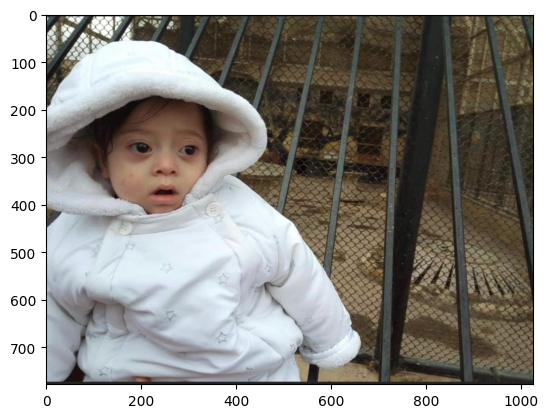

In [25]:
image = py.imread('loka.jpeg')
print(np.shape(image))
py.imshow(image)

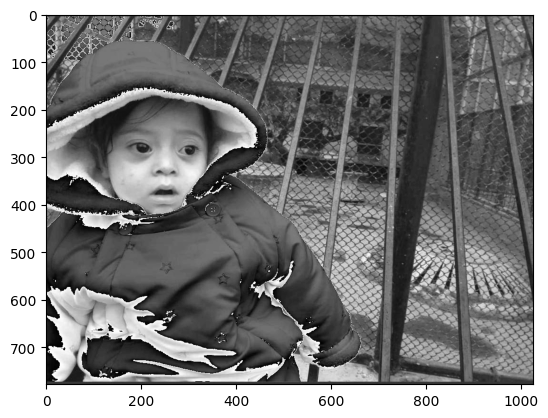

In [26]:
# gray image
gray_img = gray_lum(image, 0.5,0.5,0.5)
py.imshow(gray_img, cmap= 'gray', vmin=0, vmax=255)

In [ ]:
noised_img = noise(image, type=True)
py.imshow(mid_point(noised_img, k=5), cmap= 'gray', vmin=0, vmax=255)

In [ ]:
noised_img = noise(image, type=False)
py.imshow(geometry_mean(noised_img, k=5), cmap= 'gray', vmin=0, vmax=255)

In [ ]:
py.imshow(highpass(gray_img,1, 50, 2), cmap= 'gray', vmin=0, vmax=255)

In [ ]:
py.imshow(lowpass(image,1, 50, 2))

In [ ]:
py.imshow(smoothing_gaussian(image, 0.8))

In [ ]:
py.imshow(smoothing_nonlinear(image,type_smoothing=0, k=5))

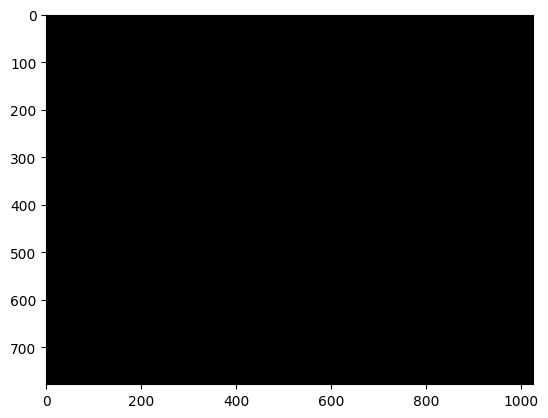

In [32]:
py.imshow(edge_detection(gray_img, type_edge=1, type_padding=False), cmap= 'gray', vmin=0, vmax=1)

In [ ]:
py.imshow(image_quantization(image, 5))

In [ ]:
py.imshow(reverse_mapp(image, h_factor=2, w_factor=3, type_=False))

In [ ]:
py.imshow(brightness(image, 220))

In [ ]:
py.imshow(contrast(image, 10, 245))

In [ ]:
py.imshow(fit_equalization(image))
